In [65]:
import json
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import random 
random.seed(1704)
import pandas as pd

# Own modules
import filepaths as fp


# 0 Loading in data

In [47]:
# Import data from json file with uft-8 encoding so that \xa0 is not a problem. 
with open(fp.DATA_PATH / 'data.json', 'r', encoding='utf-8') as f:
    retsinfo = json.load(f)

# Replace \xa0 with a space in the loaded data
def replace_nbsp(obj):
    if isinstance(obj, dict):
        return {k: replace_nbsp(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [replace_nbsp(i) for i in obj]
    elif isinstance(obj, str):
        return obj.replace('\xa0', ' ')
    else:
        return obj

retsinfo = replace_nbsp(retsinfo)

In [89]:
# A key is called "shortName" and contains the law number.
def inspect_a_law(law_number_shortname):
    for law in retsinfo:
        if law['shortName'] == law_number_shortname:
            return law
        
def get_paragraph(law, paragraph_number):
    for chapter in law['kapitler']:
        for paragraph in chapter['paragraffer']:
            if paragraph['nummer'] == f'§ {paragraph_number}.':
                # Print index for chapter and paragraph
                print(f'Chapter: {law["kapitler"].index(chapter)}')
                print(f'Paragraph: {chapter["paragraffer"].index(paragraph)}')
                return paragraph

law = inspect_a_law('LBK nr 928 af 28/06/2024')
paragraph = get_paragraph(law, '45 d')
paragraph

Chapter: 13
Paragraph: 6


{'nummer': '§ 45 d.',
 'index': 6,
 'stk': [{'tekst': 'Se note 2. Se note 2. virksomheder, der indsamler affald, virksomheder, der indsamler affald, affaldstransportører, anlæg, der behandler genanvendeligt erhvervsaffald, forhandlere og mæglere af affald og personer, der har bevis for at kunne forestå indberetning af data og miljømæssig forsvarlig håndtering af affaldet, jf. § 7, stk. 3, nr. 4.',
   'index': 0},
  {'tekst': 'Klima-, energi- og forsyningsministeren kan endvidere fastsætte regler om virksomheders, anlægs, transportørers, forhandleres og mægleres og personers pligt til at tilmelde sig registrene og om deres pligt til at indberette oplysninger hertil.',
   'index': 1}]}

In [88]:
print(law['kapitler'][10]['paragraffer'])

[{'nummer': '§ 19.', 'index': 0, 'stk': [{'tekst': 'Stoffer, produkter og materialer, der kan forurene grundvand, jord og undergrund, må ikke uden tilladelse nedgraves i jorden, nedgraves i jorden, udledes eller oplægges på jorden eller afledes til undergrunden.', 'index': 0}, {'tekst': 'Beholdere med de stoffer, produkter og materialer, der er nævnt i stk. 1, må heller ikke uden tilladelse være nedgravet i jorden.', 'index': 1}, {'tekst': 'Tætte beholdere, der alene anvendes til ajle, gylle, ensilagesaft, mælkerumsvand og møddingvand, må dog være nedgravet uden tilladelse efter stk. 2.', 'index': 2}, {'tekst': 'Tilladelse efter stk. 1 og 2 gives af kommunalbestyrelsen, medmindre miljøministeren fastsætter andre regler.', 'index': 3}, {'tekst': 'Ministeren kan fastsætte regler for at sikre, at jord og grundvand ikke forurenes eller udsættes for fare for forurening med de stoffer, produkter og materialer, der er nævnt i stk. 1.', 'index': 4}]}, {'nummer': '§ 19 a.', 'index': 1, 'stk': [

# 1 Inspecting data

In [48]:
retsinfo[0].keys()

dict_keys(['_id', 'AccessionNumber', 'DocumentTitle', 'Year', 'DiesSigni', 'Status', 'PopularTitle', 'Number', 'Ministry', 'UniqueDocumentId', 'changes', 'kapitler', 'Dato', 'url', 'dokumentType', 'shortName'])

In [49]:
# Inspecting
retsinfo[0]['kapitler'][1]['paragraffer'][0]

{'nummer': '§ 2.',
 'index': 0,
 'stk': [{'tekst': 'Ret til fravær efter denne lov omfatter alle forældre.',
   'index': 0},
  {'tekst': 'Dagpenge efter denne lov ydes i form af barselsdagpenge til lønmodtagere og selvstændige erhvervsdrivende.',
   'index': 1},
  {'tekst': 'Det er en betingelse for retten til barselsdagpenge for de personer, som er nævnt i stk. 2, at personen opfylder beskæftigelseskravet efter § 27 for lønmodtagere eller § 28 for selvstændige erhvervsdrivende.',
   'index': 2},
  {'tekst': 'Barselsdagpenge, som lønmodtagere har ret til efter stk. 2 og 3, kan udbetales til arbejdsgivere, der har udbetalt løn under fraværet, jf. § 39, stk. 1.',
   'index': 3},
  {'tekst': 'Beskæftigelsesministeren fastsætter særlige regler om barselsdagpenge til søfarende.',
   'index': 4}]}

In [50]:
# Ide: tjek længder af paragraffer. Hvis de er omkring 450 tokens kan det være at det kun er en af gangen der skal retrieves.
# Hvis det er tilfældet kan du måske frasortere alle paragraffer der er længere end 512 minus 50 tokens (context window minus maks længde genereret tekst)

rag_list = []

idx = 0

for lov in tqdm(retsinfo):
    for kapitel in lov['kapitler']:
        lov_navn = lov['shortName']
        for paragraffer in kapitel['paragraffer']:
            temp_paragraf_dict = {}
            temp_paragraf_dict['paragraf_nr'] = paragraffer['nummer']
            temp_paragraf_dict['lovnavn'] = lov_navn
            temp_paragraf_list = []
            for styk in paragraffer['stk']:
                temp_paragraf_list.append(styk['tekst'])
            temp_paragraf_dict['text'] = ' '.join(temp_paragraf_list)
            rag_list.append(temp_paragraf_dict)

100%|██████████| 1637/1637 [00:00<00:00, 29523.13it/s]


In [51]:
rag_list[40639]

{'paragraf_nr': '§ 37.',
 'lovnavn': 'LBK nr 100 af 30/01/2013',
 'text': 'Indtil kulturministeren efter denne lov har udpeget de biblioteker, der skal virke som centralbiblioteker, opretholdes de hidtidige centralbiblioteker, jf. § 8 i lov nr. 1100 af 22. december 1993 om folkebiblioteker m.v. Endvidere opretholdes tilskudsordningen til Københavns og Frederiksberg Kommuner til den del af biblioteksvirksomheden, der svarer til centralbiblioteksvirksomheden, jf. § 11 i nævnte lov. Folkebibliotekernes adgang til at opkræve en afgift for overskridelse af lånetiden, jf. § 18 i lov nr. 1100 af 22. december 1993 om folkebiblioteker m.v., opretholdes indtil den 31. december 2000.'}

In [52]:
# Tokenizing all the paragraffer to see how long they generally are

from transformers import AutoTokenizer, T5ForConditionalGeneration

# Load the pretrained T5 model and tokenizer
model_name = "strombergnlp/dant5-large"  
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)


/Users/asgerkromand/miniconda3/envs/deep/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [53]:
# Creating a function to tokenize

#max_length = 512-50

def count_tokens(list):
    temp_list = []
    for item in tqdm(list):
        temp_list.append(len(tokenizer(item, return_tensors="pt", padding=True, truncation=True)['input_ids'][0]))
    return temp_list


In [54]:
# Creating the skeleton for the function with an example

len(tokenizer(rag_list[0]['text'], return_tensors="pt")['input_ids'][0])

104

In [55]:
# Creating a list of the token_lengths

test_list = [item['text'] for item in rag_list]

len_tokens = count_tokens(test_list)

100%|██████████| 42593/42593 [00:29<00:00, 1464.05it/s]


In [56]:
len(rag_list)

42593

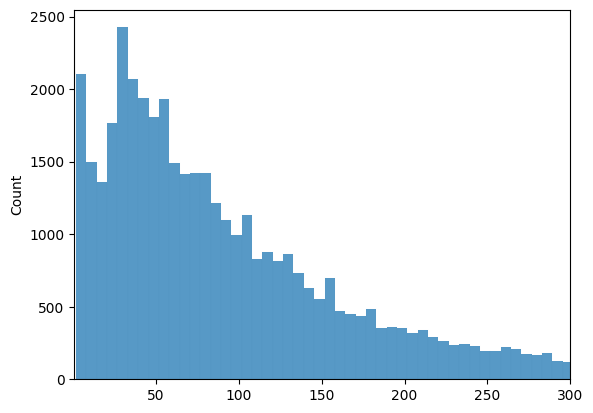

In [57]:
# Plotting the distribution of the text token lengths. This is important for RAG, as the documents being retrieved there will be on paragraf-level

fig, ax = plt.subplots()
sns.histplot(len_tokens, ax=ax)
ax.set_xlim(1, 300)
plt.show()

In [ ]:
# write list to jsonl with uft-8 encoding
with open(fp.OUTPUT_PATH / 'rag_list.jsonl', 'w', encoding='utf-8') as file:
    for item in rag_list:
        file.write(json.dumps(item) + '\n')

# Filter for index 0-14297
rag_list_batch_1 = rag_list[0:14297]
rag_list_batch_2 = rag_list[14297:28394]
rag_list_batch_3 = rag_list[28394:]

# Draw a random sample of 45 paragraphs with seed 1704 for each batch
rag_list_batch_1_sample = random.sample(rag_list_batch_1, 45) # Asger
#rag_list_batch_2_sample = random.sample(rag_list_batch_2, 45) # Andreas
#rag_list_batch_3_sample = random.sample(rag_list_batch_3, 45) # Adam

In [78]:
# Defining columns for a dataframe with samples for RAG-"QA" construction
columns = ['question', 'answer', 'paragraph_text', 'pnumber', 'law_name']

# Creating a dataframe for each batch
questions = ['' for i in range(len(rag_list_batch_1_sample))]
answers = ['' for i in range(len(rag_list_batch_1_sample))]
paragraph_texts = [paragraph['text'] for paragraph in rag_list_batch_1_sample]
pnumbers = [pnumber for paragraph in rag_list_batch_1_sample if (pnumber:=paragraph['paragraf_nr'].replace('§', '').replace('.', '').strip())]
law_names = [paragraph['lovnavn'] for paragraph in rag_list_batch_1_sample]

df_batch_1 = pd.DataFrame(list(zip(questions, answers, paragraph_texts, pnumbers, law_names)), columns=columns)

# Output the dataframe to a csv file
df_batch_1.to_csv(fp.OUTPUT_PATH / 'rag_batch_1.csv', index=True)


In [79]:
df_batch_1

,question,answer,paragraph_text,pnumber,law_name
0,,,Finanstilsynet kan påbyde et fondsmæglerselska...,242,LBK nr 232 af 01/03/2024
1,,,"I virksomheder med 10 ansatte eller derover, s...",40 e,LBK nr 76 af 24/01/2024
2,,,"Se note 2. Se note 2. virksomheder, der indsam...",45 d,LBK nr 928 af 28/06/2024
3,,,"Er en lønmodtager syg, når ferien begynder, ha...",12,LBK nr 152 af 20/02/2024
4,,,Bopælskommunen afholder udgifter forbundet med...,249,LBK nr 1015 af 05/09/2024
5,,,Statens tilskud til den enkelte kommunes små s...,16 b,LBK nr 1473 af 30/11/2023
6,,,Er det ultimative moderselskab hjemmehørende i...,75,LOV nr 1535 af 12/12/2023
7,,,Børne- og undervisningsministeren fastsætter r...,49 a,LBK nr 146 af 14/02/2024
8,,,"Rådet og personer, som rådet har bemyndiget he...",11,LBK nr 63 af 19/01/2024
9,,,"Beskæftigelsesministeren fastsætter regler om,...",8,LBK nr 280 af 01/03/2024
